In [328]:
import numpy as np
import matplotlib.pyplot as plt

In [329]:
def zScoreScale(x):
    data = x
    mean = data.mean()
    sig = np.sqrt(((data - mean)**2).sum())
    scaled_x = np.zeros(x.shape)
    
    scaled_data = (data - mean)/sig
    for i in range(x.shape[1]):
        scaled_x[:,i] = scaled_data[:,i]
    return scaled_x, mean, sig

def zScoreDescale(x, mean, sig):
    scaled_data = x
    descaled_data = scaled_data * sig + mean
    
    descaled_x = np.zeros(x.shape)
    for i in range(x.shape[1]):
        descaled_x[:,i] = descaled_data[:,i]
        
    return descaled_x

In [371]:
class BinaryLogisticalRegression:
    
    # Construtor
    def __init__(self, x, y, addOnes = True):
        if addOnes:
            self.x = np.c_[np.ones(x.shape[0]), x]
        else:
            self.x = x
        self.y = y
        self.w = np.zeros(self.x.shape[1]).reshape(-1,1)
        self.MSE = 0.0
    
    # Getters
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getW(self):
        return self.w
    
    def getMSE(self):
        return self.MSE
    
    # Setters
    def setX(self, x, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
        self.x = x
        self.w = np.zeros(self.x.shape[1]).reshape(-1,1)
    
    def setY(self, y):
        self.y = y
    
    # Métodos
    def sigmoid(self, z):
        return (1/(1 + np.exp(-1 * z)))
    
    def trainGD(self, alpha = 0.1, l2 = 0.01, max_iterations = 100):
        
        n = len(self.y)
        yhat = np.zeros(n).reshape(-1,1)
        e = np.zeros(n).reshape(-1,1)
        
        for t in range(max_iterations):
            
            yhat = self.sigmoid(self.x @ self.w)
            e = self.y - yhat
            
            self.w = self.w + (alpha/n) * self.x.T @ e  
        
        self.MSE = ((e ** 2).sum())/(2*n)
    
    def test(self):
        return self.y - (self.x @ self.w)
    
    def predict(self, x, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
        y_pred = self.sigmoid(x @ self.w)
        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0.5] = 0
        return y_pred

In [331]:
class MulticlassLogisticalRegression:
    
    # Construtor
    def __init__(self, x, y, addOnes = True):
        if addOnes:
            self.x = np.c_[np.ones(x.shape[0]), x]
        else:
            self.x = x
        self.y = y
        self.w = np.zeros((self.x.shape[1], y.shape[1]))
    
    # Getters
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getW(self):
        return self.w
    
    def getMSE(self):
        return self.MSE
    
    # Setters
    def setXY(self, x, y, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
        self.x = x
        self.y = y
        self.w = np.zeros((self.x.shape[1], y.shape[1]))
    
    # Métodos
    def softmax(self, w, x):
        numerator = np.exp(x @ w)
        denominator = np.sum(np.exp(x @ w), axis=1).reshape(-1,1)
        return numerator/denominator
    
    def trainGD(self, alpha = 0.1, max_iterations = 100):
    
        n = self.y.shape[0]
        yhat = np.zeros(self.y.shape)
        e = np.zeros(self.y.shape)
                 
        for t in range(max_iterations):
            yhat = self.softmax(self.w, self.x)
            e = self.y - yhat
            
            self.w = self.w + (alpha/n) * self.x.T @ e
    
    def test(self):
        return self.y - (self.x @ self.w)
    
    def predict(self, x, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
            
        probabilities = self.softmax(self.w, x)
        max_indexes = np.argmax(probabilities, axis=1)
        
        prediction = np.zeros(probabilities.shape)
        prediction[np.arange(len(max_indexes)), max_indexes] = 1
        
        #print(prediction)
        
        return prediction

In [332]:
class NaiveBayesGaussiano:
    
    # Construtor 
    def __init__(self, x, y):
        self.classes = np.eye(y.shape[1])
        self.n_per_class = np.zeros((y.shape[1], 1))
        self.class_priors = np.zeros((y.shape[1], 1)) # Probabilidade de cada classe
        self.means = np.zeros((self.classes.shape[1], x.shape[1]))
        self.variances = np.zeros((self.classes.shape[1], x.shape[1], x.shape[1]))
        
        # Calcula n_per_class
        for line in y:
            for i in range(0, len(line)):
                if line[i] == 1:
                    self.n_per_class[i] += 1
                    break
        
        # Calcula class_priors
        for i in range(0, len(self.class_priors)):
            self.class_priors[i] = self.n_per_class[i]/self.n_per_class.sum()
        
        # Calcula a média de cada atributo para cada classe
        for i in range(0, y.shape[0]):
            for c in range(self.classes.shape[0]):
                if np.array_equal(y[i], self.classes[c]):
                    self.means[c] += x[i]
                    break      
        for clss in range(0, y.shape[1]):
            self.means[clss, :] = self.means[clss, :]/self.n_per_class[clss]
    
        # Calcula a variância de cada feature
        for clss in range(self.classes.shape[0]):
            for feature in range(x.shape[1]):
                self.variances[clss, feature, feature] = np.sum((x[y[:, clss] == 1, feature] - self.means[clss, feature])**2)/(self.n_per_class[clss] - 1)
    
    def predict(self, x):
        probs = np.zeros((x.shape[0], self.classes.shape[0]))
        y_pred = np.zeros(probs.shape)
        for i in range(x.shape[0]):
            for clss in range(self.classes.shape[0]):
                probs[i, clss] = np.log(self.class_priors[clss])
                probs[i, clss] -= 0.5 * np.sum(np.log(2 * np.pi * self.variances[clss, :].sum()))
                probs[i, clss] -= 0.5 * np.sum(((x[i] - self.means[clss, :])**2)/self.variances[clss, :].sum())
        for i in range(x.shape[0]):
            y_pred[i] = self.classes[np.argmax(probs[i])]
    
        return y_pred

In [333]:
class DiscriminanteGaussiano:
    
    # Construtor 
    def __init__(self, x, y):
        self.classes = np.eye(y.shape[1])
        self.n_per_class = np.zeros((y.shape[1], 1))
        self.class_priors = np.zeros((y.shape[1], 1)) # Probabilidade de cada classe
        self.means = np.zeros((self.classes.shape[1], x.shape[1]))
        self.variances = np.zeros((self.classes.shape[1], x.shape[1], x.shape[1]))
        
        # Calcula n_per_class
        for line in y:
            for i in range(0, len(line)):
                if line[i] == 1:
                    self.n_per_class[i] += 1
                    break
        
        # Calcula class_priors
        for i in range(0, len(self.class_priors)):
            self.class_priors[i] = self.n_per_class[i]/self.n_per_class.sum()
        
        # Calcula a média de cada atributo para cada classe
        for i in range(0, y.shape[0]):
            for c in range(self.classes.shape[0]):
                if np.array_equal(y[i], self.classes[c]):
                    self.means[c] += x[i]
                    break      
        for clss in range(0, y.shape[1]):
            self.means[clss, :] = self.means[clss, :]/self.n_per_class[clss]
    
        
        # Calcula a variância de cada feature para cada classe
        for clss in range(self.classes.shape[0]):
            self.variances[clss] = np.cov(x[y[:, clss] == 1, :], rowvar=False)/self.n_per_class[clss]
            self.variances[clss] += np.identity(self.variances.shape[1]) * 1e-10
            
    def predict(self, x):
        probs = np.zeros((x.shape[0], self.classes.shape[0]))
        y_pred = np.zeros(probs.shape)
        for i in range(x.shape[0]):
            for clss in range(self.classes.shape[0]):
            
                det = np.linalg.det(self.variances[clss])
                inv = np.linalg.inv(self.variances[clss])
            
                probs[i, clss] = np.log(self.class_priors[clss])
                probs[i, clss] -= 0.5 * np.log(det)
                probs[i, clss] -= 0.5 * (x[i] - self.means[clss, :]) @ inv @ (x[i] - self.means[clss, :]).T
                
        for i in range(x.shape[0]):
            y_pred[i] = self.classes[np.argmax(probs[i])]
            
        return y_pred

In [334]:
def kfold(data):
    np.random.seed(1200)
    folds = []
    splits = 10
    indices = np.random.permutation(data.shape[0])
    folds_idx = np.array_split(indices, splits)
        
    for i in range(0, splits):
        train_idx = np.concatenate(folds_idx[:i] + folds_idx[i+1:])
        test_idx = folds_idx[i]
        folds.append((train_idx, test_idx))
    
    return folds

# Questão 1

Professor, quando fiz meu algoritmo de regressão logística binária usando GD, testei num dataset pequeno e ele funcionou sem problemas. Porém, quando testo no dataset da questão, o resultado da predição inteira é de uma classe só, com pesos bem similares. Passei horas analisando o código e não consegui encontrar o problema.

In [366]:
data = np.genfromtxt("breastcancer.csv", delimiter=',')

x = data[:, :30]
y = data[:, 30].reshape(-1, 1)

scaled_x, mean, sig = zScoreScale(x)

one_hot_y = np.zeros((x.shape[0], 2))
for l in range(len(y)):
    if y[l] == 1:
        one_hot_y[l] = np.array([1, 0])
    else:
        one_hot_y[l] = np.array([0, 1])

folds = kfold(x)
acuracias = np.zeros((3, 10, 2))

for f, (train_idx, test_idx) in enumerate(folds):
#(train_idx, test_idx) = folds[0]

    x_train = scaled_x[train_idx, :]
    y_train = y[train_idx].reshape(-1,1)
    one_hot_y_train = one_hot_y[train_idx]

    x_test = scaled_x[test_idx, :]
    y_test = y[test_idx].reshape(-1,1)
    one_hot_y_test = one_hot_y[test_idx]

    logistical_gd = BinaryLogisticalRegression(x_train, y_train)
    gaussian_discriminant = DiscriminanteGaussiano(x_train, one_hot_y_train)
    gaussian_naive_bayes = NaiveBayesGaussiano(x_train, one_hot_y_train)

    logistical_gd.trainGD(alpha = 0.1, max_iterations = 1000)
    yhat_lgd = logistical_gd.predict(x_test)
    #print(logistical_gd.getW())
    #print(yhat_lgd)

    yhat_gnb = gaussian_naive_bayes.predict(x_test)
    yhat_g_disc = gaussian_discriminant.predict(x_test)
    
    
    n_per_class = np.zeros((one_hot_y_test.shape[1], 1))
    for line in one_hot_y_test:
        for i in range(0, len(line)):
            if line[i] == 1:
                n_per_class[i] += 1
                break
    
    for i, clss in enumerate(one_hot_y_test):
        if ((yhat_lgd[i] == 0) and (clss[1] == 1)) or ((yhat_lgd[i] == 1) and (clss[0] == 1)):
            if clss[0] == 1:
                acuracias[0, f, 0] += 1
            else:
                acuracias[0, f, 1] += 1
        
        if np.array_equal(clss, yhat_gnb[i]):
            if clss[0] == 1:
                acuracias[1, f, 0] += 1
            else:
                acuracias[1, f, 1] += 1
                
        if np.array_equal(clss, yhat_g_disc[i]):
            if clss[0] == 1:
                acuracias[2, f, 0] += 1
            else:
                acuracias[2, f, 1] += 1
    
    acuracias[0, f, 0] /= n_per_class[0]
    acuracias[0, f, 1] /= n_per_class[1]
    acuracias[1, f, 0] /= n_per_class[0]
    acuracias[1, f, 1] /= n_per_class[1]
    acuracias[2, f, 0] /= n_per_class[0]
    acuracias[2, f, 1] /= n_per_class[1]

#print(acuracias)

print("Análise da Regressão Logística(GD):\n")
print("Média de acurácia:                 ", acuracias[0].mean())
print("Desvio padrão da acurácia:         ", acuracias[0].std())
print("Média da classe positiva:          ", acuracias[0, :, 0].mean())
print("Desvio padrão da classe positiva:  ", acuracias[0, :, 0].std())
print("Média da classe Negativa:          ", acuracias[0, :, 1].mean())
print("Desvio padrão da classe positiva:  ", acuracias[0, :, 1].std())

print("\n--------------------------------------------------\n")

print("Análise do Naive Bayes:\n")
print("Média de acurácia:                 ", acuracias[1].mean())
print("Desvio padrão da acurácia:         ", acuracias[1].std())
print("Média da classe positiva:          ", acuracias[1, :, 0].mean())
print("Desvio padrão da classe positiva:  ", acuracias[1, :, 0].std())
print("Média da classe Negativa:          ", acuracias[1, :, 1].mean())
print("Desvio padrão da classe positiva:  ", acuracias[1, :, 1].std())

print("\n--------------------------------------------------\n")

print("Análise do discriminante gaussiano:\n")
print("Média de acurácia:                 ", acuracias[2].mean())
print("Variância da acurácia:             ", acuracias[2].var())
print("Média da classe positiva:          ", acuracias[2, :, 0].mean())
print("Desvio padrão da classe positiva:  ", acuracias[2, :, 0].std())
print("Média da classe Negativa:          ", acuracias[2, :, 1].mean())
print("Desvio padrão da classe positiva:  ", acuracias[2, :, 1].std())


Análise da Regressão Logística(GD):

Média de acurácia:                  0.5
Desvio padrão da acurácia:          0.5
Média da classe positiva:           0.0
Desvio padrão da classe positiva:   0.0
Média da classe Negativa:           1.0
Desvio padrão da classe positiva:   0.0

--------------------------------------------------

Análise do Naive Bayes:

Média de acurácia:                  0.8849795249573799
Desvio padrão da acurácia:          0.1103959596017686
Média da classe positiva:           0.7926406316795332
Desvio padrão da classe positiva:   0.081765808487049
Média da classe Negativa:           0.9773184182352264
Desvio padrão da classe positiva:   0.02521796842917371

--------------------------------------------------

Análise do discriminante gaussiano:

Média de acurácia:                  0.8581028003311534
Variância da acurácia:              0.0220137644003484
Média da classe positiva:           1.0
Desvio padrão da classe positiva:   0.0
Média da classe Negativa:          

# Questão 2

O algoritmo de regressão softmax tem o mesmo problema do algoritmo de regressão binária. Fiz o algorimo e testei para um dataset pequeno. Porém, quando chamo o método predict as saídas temdem a ser de uma classe só. Também passei horas tentando entender o que estava dando errado e falhei miseravelmente. Novamente, peço perdão professor, eu tentei.

In [336]:
data = np.genfromtxt("vehicle.csv", delimiter=',')

x = data[:, :18]
y = data[:, 18].reshape(-1, 1)

scaled_x, mean, sig = zScoreScale(x)

one_hot_y = np.zeros((x.shape[0], 4))
for l in range(len(y)):
    match(y[l]):
        case 0:
            one_hot_y[l] = np.array([1, 0, 0, 0])
        case 1:
            one_hot_y[l] = np.array([0, 1, 0, 0])
        case 2:
            one_hot_y[l] = np.array([0, 0, 1, 0])
        case 3:
            one_hot_y[l] = np.array([0, 0, 0, 1])

folds = kfold(x)
acuracias = np.zeros((3, 10, 4))

for f, (train_idx, test_idx) in enumerate(folds):
#(train_idx, test_idx) = folds[0]

    x_train = scaled_x[train_idx, :]
    y_train = y[train_idx].reshape(-1,1)
    one_hot_y_train = one_hot_y[train_idx]

    x_test = scaled_x[test_idx, :]
    y_test = y[test_idx].reshape(-1,1)
    one_hot_y_test = one_hot_y[test_idx]

    softmax_gd = MulticlassLogisticalRegression(x_train, one_hot_y_train)
    gaussian_discriminant = DiscriminanteGaussiano(x_train, one_hot_y_train)
    gaussian_naive_bayes = NaiveBayesGaussiano(x_train, one_hot_y_train)

    softmax_gd.trainGD(alpha = 0.1, max_iterations = 200)
    yhat_softmax = softmax_gd.predict(x_test)
    #print(logistical_gd.getW())
    #print(yhat_lgd)

    yhat_gnb = gaussian_naive_bayes.predict(x_test)
    #print(yhat_gnb)
    yhat_g_disc = gaussian_discriminant.predict(x_test)
    #print(yhat_g_disc)
    
    n_per_class = np.zeros((one_hot_y_test.shape[1], 1))
    for line in one_hot_y_test:
        for i in range(0, len(line)):
            if line[i] == 1:
                n_per_class[i] += 1
                break
    
    for i, clss in enumerate(one_hot_y_test):
        if np.array_equal(clss, yhat_softmax[i]):
            if clss[0] == 1:
                acuracias[0, f, 0] += 1
            elif clss[1] == 1:
                acuracias[0, f, 1] += 1
            elif clss[2] == 1:
                acuracias[0, f, 2] += 1
            else:
                acuracias[0, f, 3] += 1
        
        if np.array_equal(clss, yhat_gnb[i]):
            if clss[0] == 1:
                acuracias[1, f, 0] += 1
            elif clss[1] == 1:
                acuracias[1, f, 1] += 1
            elif clss[2] == 1:
                acuracias[1, f, 2] += 1
            else:
                acuracias[1, f, 3] += 1
                
        if np.array_equal(clss, yhat_g_disc[i]):
            if clss[0] == 1:
                acuracias[2, f, 0] += 1
            elif clss[1] == 1:
                acuracias[2, f, 1] += 1
            elif clss[2] == 1:
                acuracias[2, f, 2] += 1
            else:
                acuracias[2, f, 3] += 1
    
    acuracias[0, f, 0] /= n_per_class[0]
    acuracias[0, f, 1] /= n_per_class[1]
    acuracias[0, f, 2] /= n_per_class[2]
    acuracias[0, f, 3] /= n_per_class[3]
    acuracias[1, f, 0] /= n_per_class[0]
    acuracias[1, f, 1] /= n_per_class[1]
    acuracias[1, f, 2] /= n_per_class[2]
    acuracias[1, f, 3] /= n_per_class[3]
    acuracias[2, f, 0] /= n_per_class[0]
    acuracias[2, f, 1] /= n_per_class[1]
    acuracias[2, f, 2] /= n_per_class[2]
    acuracias[2, f, 3] /= n_per_class[3]
    
#print(acuracias)

print("Análise da Regressão Softmax(GD):\n")
print("Média de acurácia:                 ", acuracias[0].mean())
print("Desvio padrão da acurácia:         ", acuracias[0].std())
print("Média da classe positiva:          ", acuracias[0, :, 0].mean())
print("Desvio padrão da classe positiva:  ", acuracias[0, :, 0].std())
print("Média da classe Negativa:          ", acuracias[0, :, 1].mean())
print("Desvio padrão da classe positiva:  ", acuracias[0, :, 1].std())

print("\n--------------------------------------------------\n")

print("Análise do Naive Bayes:\n")
print("Média de acurácia:                 ", acuracias[1].mean())
print("Desvio padrão da acurácia:         ", acuracias[1].std())
print("Média da classe positiva:          ", acuracias[1, :, 0].mean())
print("Desvio padrão da classe positiva:  ", acuracias[1, :, 0].std())
print("Média da classe Negativa:          ", acuracias[1, :, 1].mean())
print("Desvio padrão da classe positiva:  ", acuracias[1, :, 1].std())

print("\n--------------------------------------------------\n")

print("Análise do Discriminante Gaussiano:\n")
print("Média de acurácia:                 ", acuracias[2].mean())
print("Variância da acurácia:             ", acuracias[2].var())
print("Média da classe positiva:          ", acuracias[2, :, 0].mean())
print("Desvio padrão da classe positiva:  ", acuracias[2, :, 0].std())
print("Média da classe Negativa:          ", acuracias[2, :, 1].mean())
print("Desvio padrão da classe positiva:  ", acuracias[2, :, 1].std())

Análise da Regressão Softmax(GD):

Média de acurácia:                  0.2713311688311688
Desvio padrão da acurácia:          0.4222434877571003
Média da classe positiva:           0.5253246753246753
Desvio padrão da classe positiva:   0.45074898782504147
Média da classe Negativa:           0.175
Desvio padrão da classe positiva:   0.35443617196894556

--------------------------------------------------

Análise do Naive Bayes:

Média de acurácia:                  0.4127574385474486
Desvio padrão da acurácia:          0.3585228258506487
Média da classe positiva:           0.01814194577352472
Desvio padrão da classe positiva:   0.022556552796702017
Média da classe Negativa:           0.3857632549511591
Desvio padrão da classe positiva:   0.08285542540852096

--------------------------------------------------

Análise do Discriminante Gaussiano:

Média de acurácia:                  0.7897849938249699
Variância da acurácia:              0.05715240118837599
Média da classe positiva:        

## Exemplo das regressões logísticas funcionando para um dataset menor
### Regressão logística binária

In [369]:
class BinaryLogisticalRegression:
    
    # Construtor
    def __init__(self, x, y, addOnes = True):
        if addOnes:
            self.x = np.c_[np.ones(x.shape[0]), x]
        else:
            self.x = x
        self.y = y
        self.w = np.zeros(self.x.shape[1]).reshape(-1,1)
        self.MSE = 0.0
    
    # Getters
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getW(self):
        return self.w
    
    def getMSE(self):
        return self.MSE
    
    # Setters
    def setX(self, x, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
        self.x = x
        self.w = np.zeros(self.x.shape[1]).reshape(-1,1)
    
    def setY(self, y):
        self.y = y
    
    # Métodos
    def logit(self, z):
        return (1/(1 + np.exp(-1 * z)))
    
    def trainGD(self, alpha = 0.1, max_iterations = 100):
    
        n = len(self.y)
        yhat = np.zeros(n).reshape(-1,1)
        e = np.zeros(n).reshape(-1,1)
                 
        for t in range(max_iterations):
            yhat = self.logit(self.x @ self.w)
            e = self.y - yhat
            
            self.w = self.w + (alpha/n) * (self.x.T @ e)
    
    def test(self):
        return self.y - (self.x @ self.w)
    
    def predict(self, x, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
        y_pred = self.logit(x @ self.w)
        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0.5] = 0
        return y_pred

[[0.]
 [0.]
 [1.]
 [1.]]


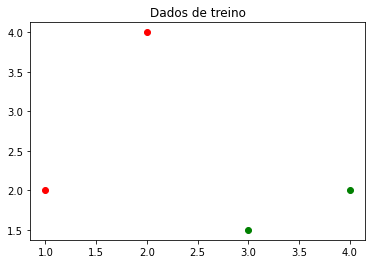

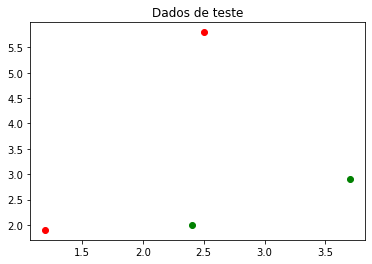

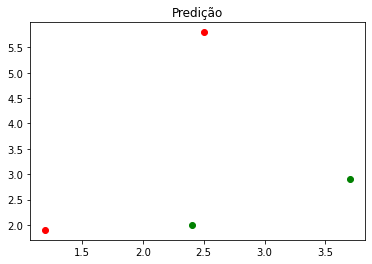

In [372]:
x = np.array([[1,   2], 
              [2,   4], 
              [3, 1.5], 
              [4,   2]])

x2 = np.array([[1.2, 1.9], 
               [2.5, 5.8], 
               [2.4, 2.0], 
               [3.7, 2.9]])

y = np.array([0, 0, 1, 1]).reshape(-1,1)

y2 = np.array([0, 0, 1, 1]).reshape(-1,1)

regression = BinaryLogisticalRegression(x, y)
regression.trainGD(alpha=0.01, max_iterations = 400)

y_predict = regression.predict(x2)

print(y_predict)

plt.title("Dados de treino")

for i in range(x.shape[0]):
    if y[i] == 0:
        plt.plot(x[i,0], x[i,1], 'ro')
    else:
        plt.plot(x[i,0], x[i,1], 'go')

plt.show()

plt.title("Dados de teste")

for i in range(x2.shape[0]):
    if y2[i] == 0:
        plt.plot(x2[i,0], x2[i,1], 'ro')
    else:
        plt.plot(x2[i,0], x2[i,1], 'go')
        
plt.show()

plt.title("Predição")

for i in range(x2.shape[0]):
    if y_predict[i] == 0:
        plt.plot(x2[i,0], x2[i,1], 'ro')
    else:
        plt.plot(x2[i,0], x2[i,1], 'go')
        
plt.show()

### Regressão softmax

In [373]:
class MulticlassLogisticalRegression:
    
    # Construtor
    def __init__(self, x, y, addOnes = True):
        if addOnes:
            self.x = np.c_[np.ones(x.shape[0]), x]
        else:
            self.x = x
        self.y = y
        self.w = np.zeros((self.x.shape[1], y.shape[1]))
        self.MSE = 0.0
    
    # Getters
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getW(self):
        return self.w
    
    def getMSE(self):
        return self.MSE
    
    # Setters
    def setXY(self, x, y, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
        self.x = x
        self.y = y
        self.w = np.zeros((self.x.shape[1], y.shape[1]))
    
    # Métodos
    def softmax(self, w, x):
        numerator = np.exp(x @ w)
        denominator = np.sum(np.exp(x @ w), axis=1).reshape(-1,1)
        return numerator/denominator
    
    def trainGD(self, alpha = 0.1, max_iterations = 100):
    
        n = self.y.shape[0]
        yhat = np.zeros(self.y.shape)
        e = np.zeros(self.y.shape)
                 
        for t in range(max_iterations):
            yhat = self.softmax(self.w, self.x)
            e = self.y - yhat
            self.w = self.w + (alpha/n * (self.x.T @ e))
                            
        self.MSE = ((e ** 2).sum())/(2*n)
    
    def test(self):
        return self.y - (self.x @ self.w)
    
    def predict(self, x, addOnes = True):
        if addOnes:
            x = np.c_[np.ones(x.shape[0]), x]
        probabilities = self.softmax(self.w, x)
        max_indexes = np.argmax(probabilities, axis=1)
        prediction = np.zeros(probabilities.shape)
        prediction[np.arange(len(max_indexes)), max_indexes] = 1
        return prediction

In [ ]:
def getMaxIndex(y):
    max_index = 0
    max_value = y[0]
    for clss in range(1, len(y)):
        if y[clss] > max_value:
            max_value = y[clss]
            max_index = clss
    return max_index

x = np.array([[1.0, 0.25], 
              [2.0,  0.5], 
              [3.5,  1.0], 
              [4.0, 1.25],
              [6.0,  2.0],
              [6.5,  2.5]])

y = np.array([[1, 0, 0], 
              [1, 0, 0], 
              [0, 1, 0], 
              [0, 1, 0],
              [0, 0, 1], 
              [0, 0, 1]])

x2 = np.array([[1.1, 0.2], 
              [2.3,  0.6], 
              [2.2,  0.8], 
              [3.9, 1.15],
              [7.0,  2.5],
              [6.8,  2.8]])

y2 = np.array([[1, 0, 0], 
              [1, 0, 0], 
              [0, 1, 0], 
              [0, 1, 0],
              [0, 0, 1], 
              [0, 0, 1]])

regression = MulticlassLogisticalRegression(x, y)
regression.trainGD(max_iterations = 1000)
regression.test()
ypredict = regression.predict(x2)


plt.title("Dados de treino")
for i in range(x.shape[0]):
    max_index = getMaxIndex(y[i])
    if max_index == 0:
        plt.plot(x[i,0], x[i,1], 'ro')
    elif max_index == 1:
        plt.plot(x[i,0], x[i,1], 'go')
    else:
        plt.plot(x[i,0], x[i,1], 'bo')
plt.show()

for i in range(x2.shape[0]):
    max_index = getMaxIndex(ypredict[i])
    if max_index == 0:
        plt.plot(x2[i,0], x2[i,1], 'ro')
    elif max_index == 1:
        plt.plot(x2[i,0], x2[i,1], 'go')
    else:
        plt.plot(x2[i,0], x2[i,1], 'bo')
plt.show()